In [37]:
#from __future__ import print_function;
import nibabel as nb;
import numpy as np;
%matplotlib inline
import matplotlib.pyplot as plt
import cortex;
import os;
import pandas as pd;
import h5py;
import nilearn as nl;
import nilearn.masking as nlmask
import sklearn as sk;
from nibabel.testing import data_path;
from ipywidgets import interact, interactive, fixed, interact_manual, widgets;
from nilearn import datasets;
from sklearn.svm import SVC
import seaborn as sns






In [2]:
hax2 = datasets.fetch_haxby(subjects=6);

In [3]:
fmri_filename = hax2.func[1]
fmri_filename

'/home/jovyan/nilearn_data/haxby2001/subj2/bold.nii.gz'

# Introduction

The research question we are looking at is: If we are given some fMRI data and the stimuli presented during the data, can we make a model that takes in fMRI data and predicts the correct stimulus label. This is important because in doing this we can tell what reigions of the brain represent what stimuli. By continously doing Multi Voxel Pattern analysis we can come to understand better what reigions of the brain are responsible for what functions. There are behavioral outcomes for this kind of model. For example, finding the Fusiform Face Area can give us insight into disorders like Prosopagnosia and where they are localized.

# Method and Dataset Description
First, we want to upload the fmri data to make predictions. The data I chose to upload for this analysis is from a study by Haxby et al. that showed significant differnces in brain reigion activation for 'house' and 'people' stimuli. 

According to the website where the data is found (http://www.pymvpa.org/datadb/haxby2001.html):

The dataset consists of 6 subjects with 12 runs per subject. In each run, the subjects passively viewed greyscale images of eight object categories, grouped in 24s blocks separated by rest periods. Each image was shown for 500ms and was followed by a 1500ms inter-stimulus interval. Full-brain fMRI data were recorded with a volume repetition time of 2.5s, thus, a stimulus block was covered by roughly 9 volumes. 



In [4]:
#full fmri scans (time included) and masks
fmri_images = []

for i in range(0,6):
    curr_filename = hax2.func[i]
    curr_file = nb.load(curr_filename)
    fmri_images += [curr_file]

#session and target data array
target_tbls = []        
for i in range(0,6):
    ith_target = hax2.session_target[i]
    target_table = pd.read_csv(ith_target)
    target_tbls += [target_table]
    
#anatomy files
anatomies = []
for i in range(0,6):
    curr_filename = hax2.func[i]
    curr_file = nb.load(curr_filename)
    anatomies += [curr_file]
    
#mask files
#masks = []
#for i in range(0,6):
    #curr_mask = nl.masking.compute_epi_mask(fmri_images[i])
   # masks += [curr_mask]


# Plot Slices to see Relevant Reigions

In the cell below we will be plotting **axial**, **coronal** and **saggital** slices and seeing what reigions in the brain the voxels we are using are selected from. To do this we will look at the raw data from the uploaded nii images. We will select one timeseries (500) to analyze what reigion our voxels are in. The reigion will be quite large (as this is a full brain scan) and will need to modified to represent ROI's later on.

This method displays knowledge learned from lecture 2-- different views of the brain.

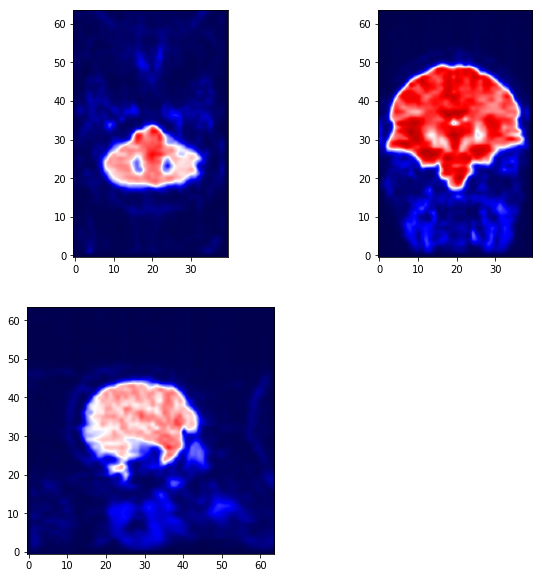

In [5]:
#plot axial, saggital and coronal slices for subj01 500ts
proxy_img = fmri_images[0]
num_sbjs = 1.1
vol_50s = proxy_img.dataobj[..., 500].T
axial_slices = vol_50s[20, :, :]
cor_slices = vol_50s[:,32,:]
sag_slices = vol_50s[:,:,32]
slices = [axial_slices,cor_slices,sag_slices]
fig = plt.figure(figsize = (10, 10))

for s in range(3):
    ax = fig.add_subplot(2,2, s+1)
    if s == 1:
        plt.imshow(slices[s], origin='lower', aspect='equal', interpolation='gaussian', cmap='seismic', vmin=0, vmax=2600)
    else:
        plt.imshow(slices[s], origin='lower', aspect='equal',  interpolation='gaussian', cmap='seismic', vmin=0, vmax=3000)


# Modeling with Warm Start Linear K Classifier

Now, that we know what voxels we are measuring, lets get into building a predictive model. To start with, using every voxel to build our predictive model would be incredibly cumbersome. Instead we want predict based on only the **statistically significant voxels**. To pick these out we create a brain map of variance over time series and only select voxels with some threshold of variance. Fortunately the Haxby dataset already has a brain mask and the Nibabel library has a function to compress our fMRI data based on the given mask.

In [6]:
#initialize model
#we will discuss model in later sections.
model = sk.linear_model.SGDClassifier(warm_start=True)

/srv/app/venv/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [7]:
from nilearn.input_data import NiftiMasker
#making masks, we can only do 4 at a time because of the large data size of the masks and the low capacity for iPython
masks = []
for i in range(4):
    proxy_img = fmri_images[i]
    img = proxy_img.dataobj[..., 0:350] #we can also only look at 350 timeseries' because looking at all 1200 would crash the notebook
    #note hax2 mask and the masker function
    mask_load = nb.Nifti1Image(nb.load(hax2.mask[:]).dataobj[..., 0:350], np.eye(4))
    masker = NiftiMasker(mask_img=mask_load,standardize=True)
    fmri_masked = masker.fit_transform(nb.Nifti1Image(img, np.eye(4)))
    masks += [fmri_masked]
    


In [59]:


brain_mask = nl.masking.compute_epi_mask(nb.Nifti1Image(img, np.eye(4)))
#anat_img = anatomies[0]
#img = proxy_img.dataobj[..., 0:150].T
anatomical = nl.masking.compute_epi_mask(nb.Nifti1Image(img, np.eye(4)))
sys.executable


'/srv/app/venv/bin/python3.6'

# Train the Model

Now that we have masks of 4/6 of our subjects functional MRI data we can train a model that takes the data as an input and predicts the stimuli presented to the subject. To do this we will **perform Multi Voxel Pattern Analysis** as described in lecture 4. To classify different brain states we will use a feature weighting linear predictor from SkLearn. 

   Aside from the fact that **Support Vector Machines are ideal for modeling large dimensional data** (which we have), the particular SVM -- SGDClassifier is attaractive because it has a **warm start option**. This means that after the intial call to train, we will be updating our features based on more data, not reseting them. SGD stands for **stochastic gradient descent**. In the readme I will explain this implementation further.
   
   

In [9]:
#train model
curr_table = target_tbls[0]
curr_table['label'], curr_table['chunks'] = curr_table['labels chunks'].str.split(' ', 1).str
Y  = curr_table[0:350]
for i in range(4):
    if i == 0:
        model.fit(masks[i], Y['label'])
    else:
        model.fit(masks[i], Y['label'])


# Test the Model

Although we did not use sklearn's train test split due to memory constraints, we are still capable of making our own train / test split. I trained the data on the first 350 timeseries' and I will test it on 600-750 timeseries. The idea train of train test split was learned from lecture.

In [10]:
#test model
proxy_img = fmri_images[1]
img = proxy_img.dataobj[..., 600:750]
mask_load = nb.Nifti1Image(nb.load(hax2.mask[:]).dataobj, np.eye(4))
masker = NiftiMasker(mask_img=mask_load,standardize=True)
fmri_masked = masker.fit_transform(nb.Nifti1Image(img, np.eye(4)))
model.score(fmri_masked, curr_table[600:750]['label'])

0.4533333333333333

# Functions (Ignore)

Below I am writing all of my methods into functions to make iterating on training data easier. This section can be ignored as it is not covering anything conceptual.

In [11]:
#num masks a list with elems 1-6, timeseries a list slice, eg: [100:400]
def masks(num_masks, timeseries1, timeseries2):
    print('building masks...')
    masks = []
    for i in num_masks:
        proxy_img = fmri_images[i]
        img = proxy_img.dataobj[..., timeseries1:timeseries2] #we can also only look at 350 timeseries' because looking at all 1200 would crash the notebook
        #note hax2 mask and the masker function
        mask_load = nb.Nifti1Image(nb.load(hax2.mask[:]).dataobj, np.eye(4))
        masker = NiftiMasker(mask_img=mask_load,standardize=True)
        fmri_masked = masker.fit_transform(nb.Nifti1Image(img, np.eye(4)))
        masks += [fmri_masked]
    return masks
    

In [12]:
#num_subjs a list with elems 1-6, timeseries a list slice, eg: [100:400]
def trainer(num_subjs, timeseries, masks):
    for i in range(len(num_subjs)):
        curr_table = target_tbls[i]
        curr_table['label'], curr_table['chunks'] = curr_table['labels chunks'].str.split(' ', 1).str
        Y  = curr_table[timeseries[0] : timeseries[1]]
        if i == 0 and timeseries[0] == 0:
            model.fit(masks[i], Y['label'])
        else:
            model.fit(masks[i], Y['label'])
    return 'data is fitted'


In [13]:
def test_model(num_subjs, ts1,ts2):
    score = []
    for i in num_subjs:
        proxy_img = fmri_images[i]
        img = proxy_img.dataobj[..., ts1:ts2]
        mask_load = nb.Nifti1Image(nb.load(hax2.mask[:]).dataobj, np.eye(4))
        masker = NiftiMasker(mask_img=mask_load,standardize=True)
        fmri_masked = masker.fit_transform(nb.Nifti1Image(img, np.eye(4)))
        score += [model.score(fmri_masked, curr_table[ts1:ts2]['label'])]
    return np.mean(score)
    

# Results

Looking at the output here, the model achieved a ~50% score on predicting features. This score can be improved by simply iterating over more data. We will do this carefully to maintain the integrity of the kernel. It is important to note that this data was actually designed to do function localization (on Fusiform Face Area) on house vs. face stimuli. Lets now train our model on the rest of the first four subjects data. 

In [14]:
#train on TS 350-700
subjects = np.arange(4)
timeseries = [350,700]
new_masks = masks(subjects, timeseries[0],timeseries[1])
trainer(subjects, timeseries, new_masks)




building masks...


'data is fitted'

In [15]:
#train on TS 700-1100
timeseries2 = [700,1000]
new_masks = masks(subjects, timeseries2[0],timeseries2[1])
trainer(subjects, timeseries2, new_masks)


building masks...


'data is fitted'

In [16]:
#train on part of last two subjects data to achieve 70 - 30% train test split
timeseries2 = [100,400]
subjects = [3,4]
new_masks = masks(subjects, timeseries2[0],timeseries2[1])
trainer(subjects, timeseries2, new_masks)



building masks...


'data is fitted'

# Test again

In [18]:
#test on last 30% of the data
test_model([3],300,500)


0.736

# Success!

The model achieved a correct classification rate on 73% of the data! This may be an unrealistic measure due to overtraining and the fact that 1/2 of the test data had been trained on before. Regardless, this correct classifcation rate is better than I had hoped and I consider the model at this point a success.

In [ ]:
#code graveyard
""""proxy_img = anatomies[i]
img = proxy_img.dataobj[..., 0:150].T
normalized_img = (img - np.mean(img)) / np.std(img)
img_filtered = normalized_img > 1
masks += [img_filtered]"""


In [ ]:
nb.load(hax2.mask[:]).shape